# importacion de librerias y carga de datos

In [100]:
import io
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns 
#from google.colab import files
upload = files.upload()
dftest = pd.read_csv("/content/202220_Laboratorio_3_data_university_admission_test.csv")
df = pd.read_csv("/content/202220_Laboratorio_3_data_university_admission_train.csv")

In [101]:
# Import all needed modules
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Perfilamiento inicial de datos

Se elimina la columna "unamed" y se modifica el titulo de la columna LOR para que coincida con la API


In [102]:
df=df.dropna()
df= df.drop (['Unnamed: 0'], axis=1)
df=df.rename(columns={"LOR ": "LOR"})
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admission Points
0,479,327,113,4,4.00,2.77,8.88,1,84.47
1,446,301,92,1,1.85,1.50,7.71,0,45.08
2,336,297,100,1,2.41,1.59,7.89,0,47.42
3,20,303,98,3,3.50,3.00,8.50,0,62.00
4,432,320,94,2,1.38,3.50,8.78,1,73.00


# Seleccion del modelo 

Se ejecutan dos escenarios de prueba para decidir que modelo implementar antes de crear el pipeline


In [113]:
data=df.copy()
data=data.dropna()
from sklearn.model_selection import train_test_split
target = data.pop('Admission Points')
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=1234)

## modelo 1: reg lineal

In [114]:
model_LR = LinearRegression()


model_LR.fit(X_train, y_train)


predict_train = model_LR.predict(X_train)
predict_test  = model_LR.predict(X_test)


print('RMSE on train data: ', mean_squared_error(y_train, predict_train)**(0.5))
print('RMSE on test data: ',  mean_squared_error(y_test, predict_test)**(0.5))

RMSE on train data:  10.150362755265514
RMSE on test data:  10.745378691806643


## modelo 2: Random Forest regressor



In [115]:

model_RFR = RandomForestRegressor(max_depth=10)


model_RFR.fit(X_train, y_train)


predict_train = model_RFR.predict(X_train)
predict_test = model_RFR.predict(X_test)

print('RMSE on train data: ', mean_squared_error(y_train, predict_train)**(0.5))
print('RMSE on test data: ',  mean_squared_error(y_test, predict_test)**(0.5))

RMSE on train data:  3.1658736390064575
RMSE on test data:  7.195274140384978


Dado que las metricas del random forest resultan mejores se decide implementar este modelo en el pipeline. Ademas se realiza una evaluacion del peso de las features para determinar su peso en la copnstruccion de los modelos.

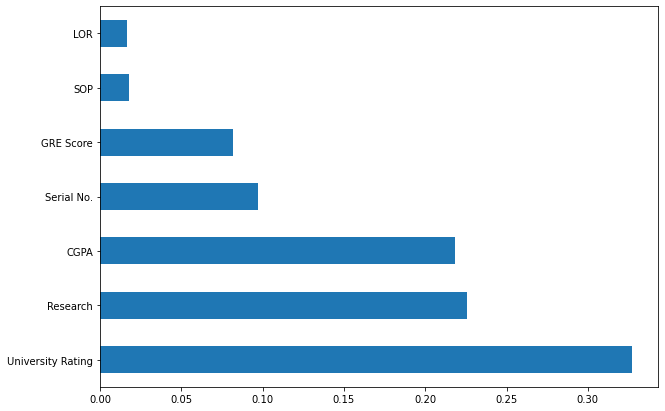

In [116]:
plt.figure(figsize=(10,7))
feat_importances = pd.Series(model_RFR.feature_importances_, index = X_train.columns)
feat_importances.nlargest(7).plot(kind='barh');

En este caso se determina dejar todos los features pero se considera para la evaluacion el university rating y el research son los que mas peso tienen en el modelo. Esto se debe ver reflejado en los resultados producidos por el API

# construccion del pipeline

In [103]:
numeric_features = ['Serial No.','GRE Score',
                    'TOEFL Score','University Rating',
                    'SOP','LOR','CGPA', 'Research']
numeric_transformer = Pipeline(steps=[
                                      ('poly',PolynomialFeatures(degree =3)),
                                      ('scaler', StandardScaler())])

In [104]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

In [105]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor (max_depth=10, random_state=0))])

In [106]:
X = df.drop('Admission Points', axis = 1)
y = df['Admission Points']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Serial No.', 'GRE Score',
                                                   'TOEFL Score',
                                                   'University Rating', 'SOP',
                                                   'LOR', 'CGPA',
                                                   'Research'])])),
                ('classifier',
                 RandomForestRegressor(max_depth=10, random_state=0))])

In [107]:
pipeline.score(X_train, y_train)

0.9761308963288688

# exportacion de los modelos y validacion final de resultados

Inicialmente se exportan los modelos con joblib

In [108]:
import joblib

In [109]:
joblib.dump(pipeline, 'pipeline.pkl')

['pipeline.pkl']

In [110]:
joblib.dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']

In [111]:
from google.colab import files
files.download('pipeline.pkl')
files.download('pipeline.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Se realiza una evaluacion final sobre el modelo descragado para verificar que se produjo un archivo .joblib que recibe los parametros apropiados y arroja un resultado acorde. 

In [112]:
from sklearn.metrics import mean_squared_error
loaded_model = joblib.load('pipeline.joblib')


pipeline_preds = loaded_model.predict(X_test)
print('RMSE on test data: ',  mean_squared_error(y_test, pipeline_preds))

RMSE on test data:  69.03561307548185
